In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import random

In [14]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
import os
print(os.listdir("H:/My Drive/jkas/Mitacs/LabRisk/Datasets"))

['archive', 'TWEETS', 'train', 'test']


In [17]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [18]:
filenames = os.listdir("H:/My Drive/jkas/Mitacs/LabRisk/Datasets/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [19]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [20]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

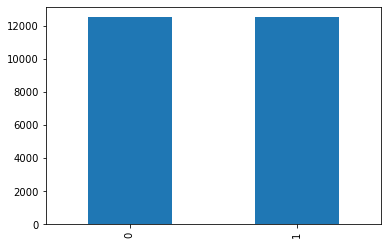

In [21]:
df['category'].value_counts().plot.bar()

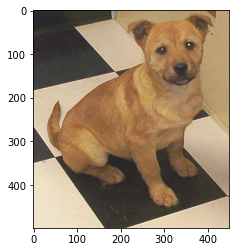

In [23]:
sample = random.choice(filenames)
image = load_img("H:/My Drive/jkas/Mitacs/LabRisk/Datasets//train/train/"+sample)
plt.imshow(image)

In [25]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [28]:
earlystop = EarlyStopping(patience=10)

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [30]:
callbacks = [earlystop, learning_rate_reduction]

In [31]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [32]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

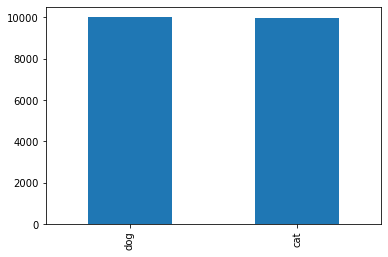

In [33]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

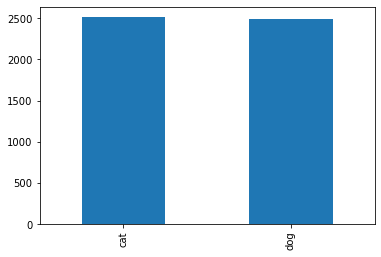

In [34]:
validate_df['category'].value_counts().plot.bar()

In [35]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "H:/My Drive/jkas/Mitacs/LabRisk/Datasets/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [38]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "H:/My Drive/jkas/Mitacs/LabRisk/Datasets/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [41]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "H:/My Drive/jkas/Mitacs/LabRisk/Datasets/train/train/",  
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


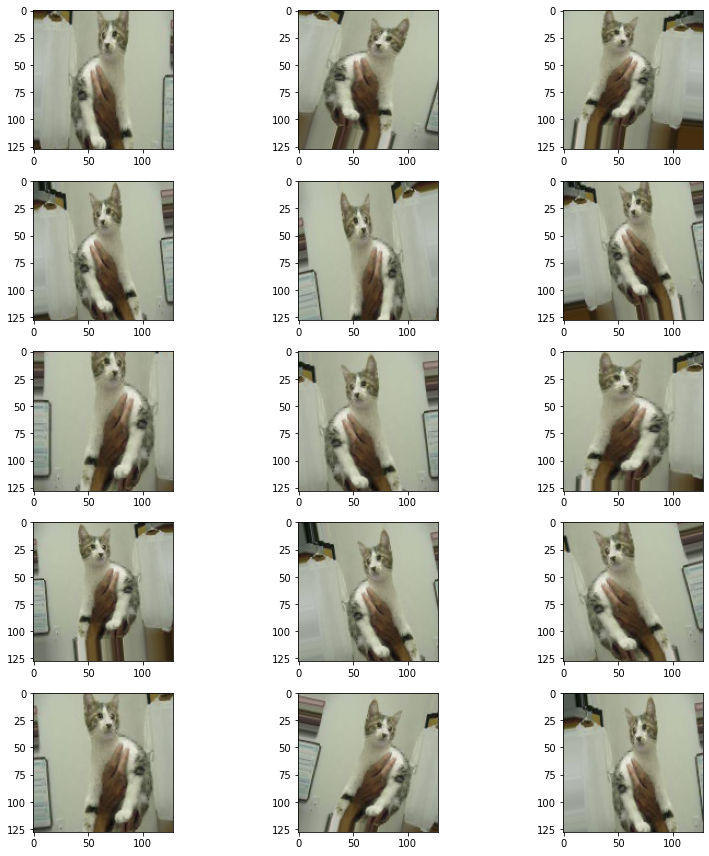

In [42]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [43]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\jkash\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1333/1333 [==============================] - 843s 632ms/step - loss: 0.7194 - accuracy: 0.6513 - val_loss: 0.6245 - val_accuracy: 0.6607
Epoch 2/50
1333/1333 [==============================] - 717s 538ms/step - loss: 0.5372 - accuracy: 0.7361 - val_loss: 0.5386 - val_accuracy: 0.7666
Epoch 3/50
1333/1333 [==============================] - 943s 707ms/step - loss: 0.4856 - accuracy: 0.7740 - val_loss: 2.7579 - val_accuracy: 0.5107
Epoch 4/50
1333/1333 [==============================] - 663s 497ms/step - loss: 0.4518 - accuracy: 0.7951 - val_loss: 0.3992 - val_accuracy: 0.8172
Epoch 5/50
1333/1333 [==============================] - 779s 584ms/step - loss: 0.4343 - accuracy: 0.8032 - val_loss: 0.3754 - val_accuracy: 0.8290
Epoch 6/50
1333/1333 [==============================] - 749s 562ms/step - loss: 0.4188 - accuracy: 0.8112 - val_loss: 0.8680 - val_accuracy: 0.6064
Epoch 7/50
1333/1333 [==============================] - 799s 600ms/step - loss: 0.3892 - accuracy: 0.8268 - val_

1333/1333 [==============================] - 672s 504ms/step - loss: 0.3003 - accuracy: 0.8714 - val_loss: 0.2768 - val_accuracy: 0.8857


In [44]:
model.save_weights("model.h5")

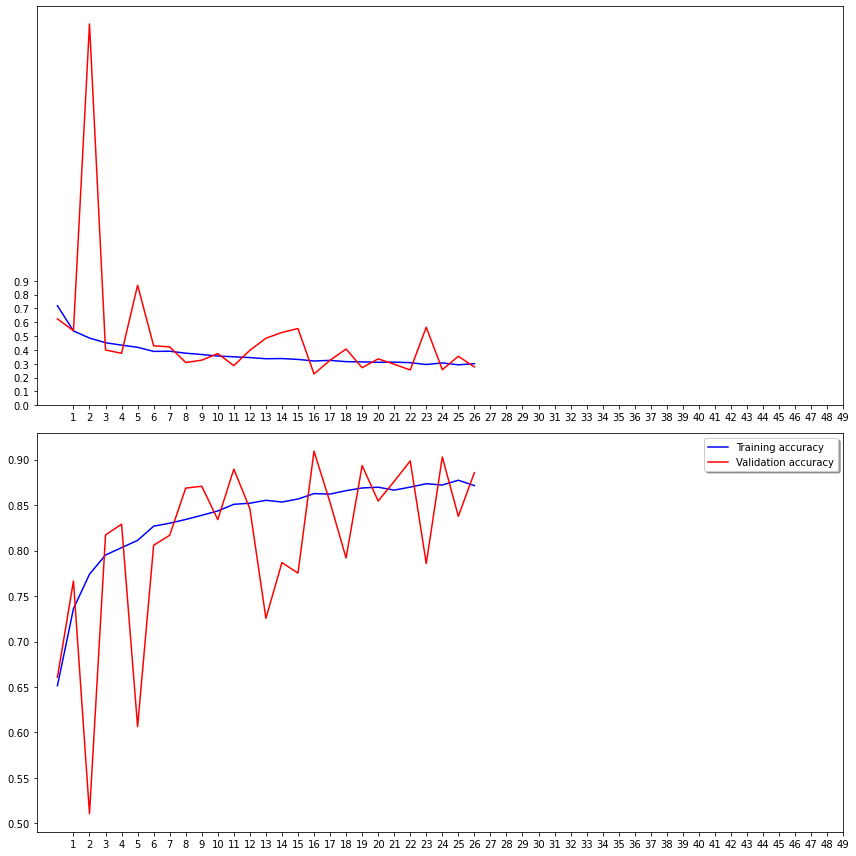

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [47]:
test_filenames = os.listdir("H:/My Drive/jkas/Mitacs/LabRisk/Datasets/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [49]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "H:/My Drive/jkas/Mitacs/LabRisk/Datasets/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [50]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\jkash\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [51]:
test_df['category'] = np.argmax(predict, axis=-1)

In [52]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [53]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<AxesSubplot:>

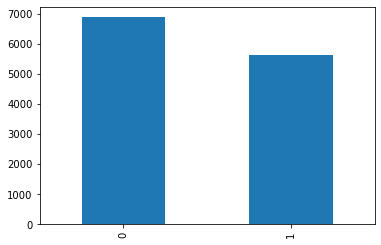

In [54]:
test_df['category'].value_counts().plot.bar()

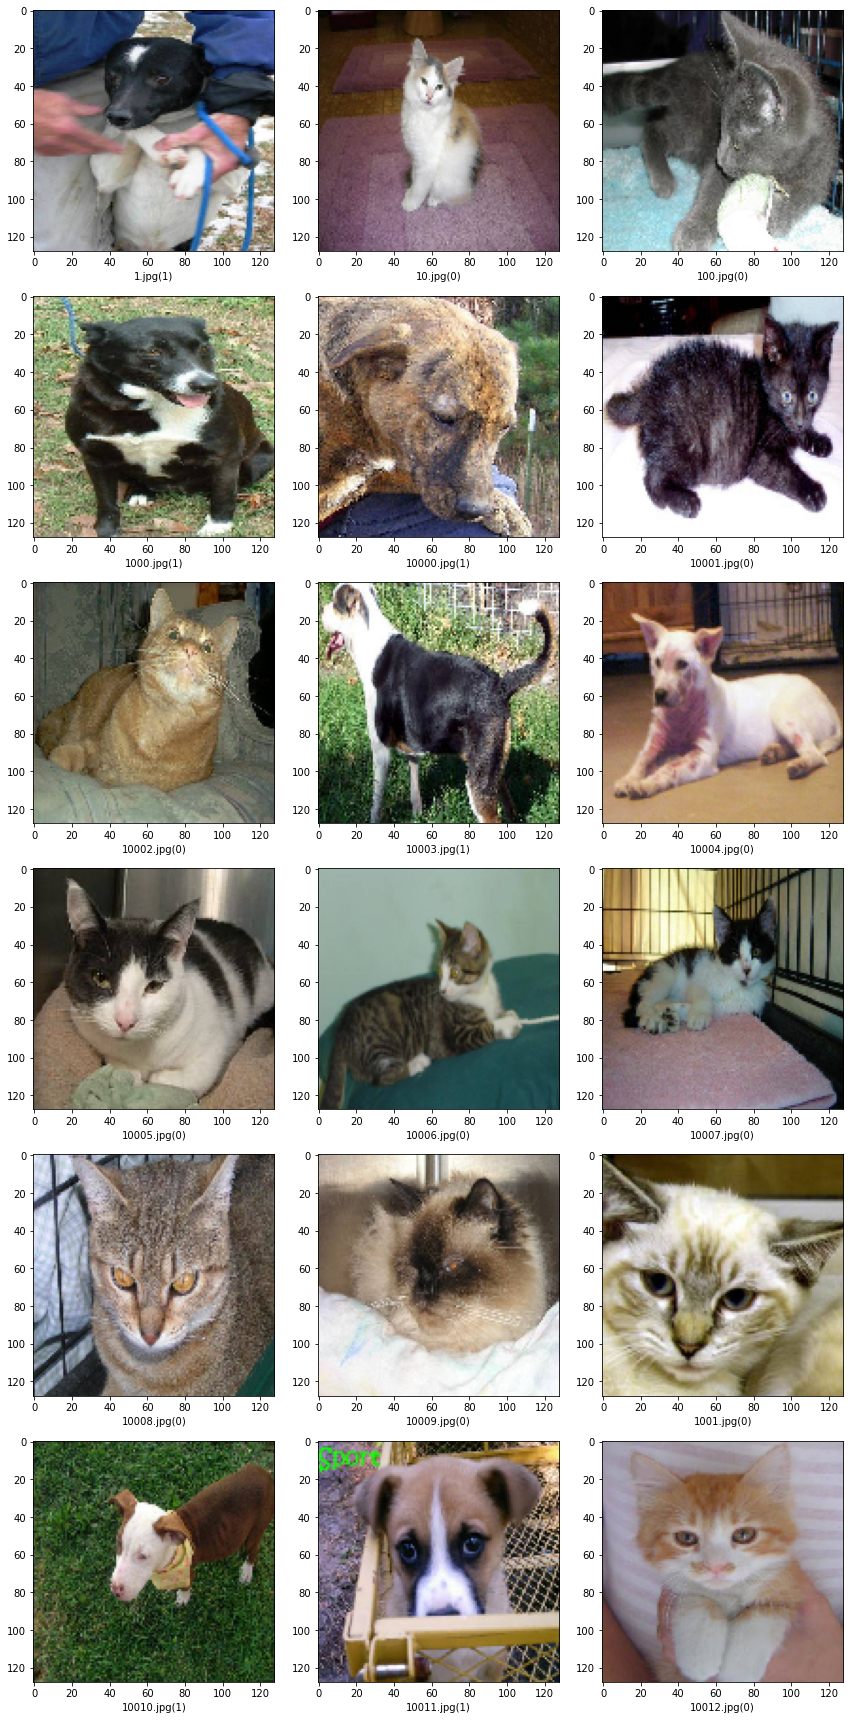

In [57]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("H:/My Drive/jkas/Mitacs/LabRisk/Datasets/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [58]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)